<a href="https://colab.research.google.com/github/chlwlgus97/17bigdata/blob/main/Model_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# 파일 경로
file_path = 'bitcoin_6m.csv'

# 데이터 로드
btc_df = pd.read_csv(file_path)

# 데이터프레임의 첫 몇 행을 출력하여 구조 확인
btc_df.head()

,open_time,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,symbol
0,2023-07-14 09:00:00,31441.6,31451.1,31437.1,31440.0,409.895,1.288859e+07,3691,171.229,5.384128e+06,BTCUSDT
1,2023-07-14 09:01:00,31440.1,31448.0,31436.5,31445.6,205.267,6.454019e+06,2242,139.739,4.393711e+06,BTCUSDT
2,2023-07-14 09:02:00,31445.5,31459.5,31428.2,31459.4,324.958,1.021708e+07,3310,146.179,4.596811e+06,BTCUSDT
3,2023-07-14 09:03:00,31459.5,31459.5,31437.9,31439.9,181.418,5.705181e+06,1939,41.867,1.316560e+06,BTCUSDT
4,2023-07-14 09:04:00,31439.9,31440.0,31416.0,31417.4,443.662,1.394171e+07,3529,137.522,4.321646e+06,BTCUSDT


In [3]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799203 entries, 0 to 799202
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   open_time    799203 non-null  object 
 1   open         799203 non-null  float64
 2   high         799203 non-null  float64
 3   low          799203 non-null  float64
 4   close        799203 non-null  float64
 5   volume       799203 non-null  float64
 6   quote_av     799203 non-null  float64
 7   trades       799203 non-null  int64  
 8   tb_base_av   799203 non-null  float64
 9   tb_quote_av  799203 non-null  float64
 10  symbol       799203 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 67.1+ MB


In [4]:
# 데이터 로드 및 필요한 컬럼만 선택
# btc_df = pd.read_csv('your_btc_data.csv')
btc_df = btc_df[['open', 'high', 'low', 'close', 'volume', 'quote_av', 'trades']]

# 시퀀스 데이터와 타겟 데이터 생성 함수 (shift를 사용하여 수정)
def create_sequences_with_shift(data, sequence_length, target_step):
    sequences = []
    targets = []
    for start_pos in range(len(data) - sequence_length - target_step + 1):
        end_pos = start_pos + sequence_length
        seq = data.iloc[start_pos:end_pos].values
        target = data.iloc[end_pos + target_step - 1]['close']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 20
target_step = 5

X, y = create_sequences_with_shift(btc_df, sequence_length, target_step)

# 데이터셋 분리 (순차적 분리)
train_size = int(len(X) * 0.7)
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# 훈련 데이터에서 다시 훈련 및 검증 데이터 분리 (순차적 분리)
train_size = int(len(X_train_full) * 0.8)
X_train, X_val = X_train_full[:train_size], X_train_full[train_size:]
y_train, y_val = y_train_full[:train_size], y_train_full[train_size:]

# StandardScaler 적용
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_reshaped = X_val.reshape(-1, X_val.shape[2])
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_test_scaled = scaler.transform(X_test_reshaped)

# 스케일된 데이터를 원래 차원으로 복원
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [5]:
# LSTM 모델 구성
model = Sequential([
    LSTM(50, activation='linear', input_shape=(sequence_length, X_train.shape[2])),
    Dense(5)
])

# 모델 컴파일
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# 모델 학습
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=5, batch_size=32)

Epoch 1/5
13986/13986 [==============================] - 327s 23ms/step - loss: 5993134.5000 - mae: 705.2172 - val_loss: 1916009.8750 - val_mae: 1037.6201
Epoch 2/5
13986/13986 [==============================] - 318s 23ms/step - loss: 230861.7188 - mae: 201.6014 - val_loss: 1386113.6250 - val_mae: 875.4149
Epoch 3/5
13986/13986 [==============================] - 316s 23ms/step - loss: 184930.7812 - mae: 162.2909 - val_loss: 1920115.5000 - val_mae: 999.7590
Epoch 4/5
13986/13986 [==============================] - 316s 23ms/step - loss: 183124.5938 - mae: 162.4602 - val_loss: 1503624.6250 - val_mae: 948.1473
Epoch 5/5
13986/13986 [==============================] - 320s 23ms/step - loss: 140655.1875 - mae: 126.3437 - val_loss: 1003642.3125 - val_mae: 619.4556


3497/3497 [==============================] - 17s 5ms/step


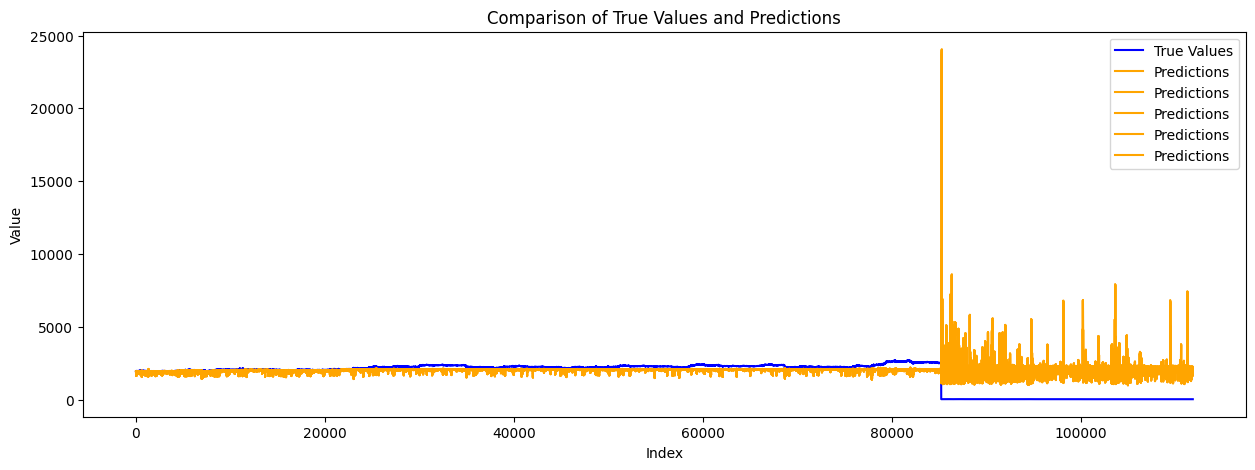

In [8]:
import matplotlib.pyplot as plt

# 검증 데이터셋에 대한 예측 수행
y_val_pred = model.predict(X_val_scaled)

# 예측값과 실제값의 차이를 시각화
plt.figure(figsize=(15, 5))  # 그래프의 가로 세로 크기 설정
plt.plot(y_val, label='True Values', color='blue')  # 실제값 파란색으로 표시
plt.plot(y_val_pred, label='Predictions', color='orange')  # 예측값 주황색으로 표시
plt.title('Comparison of True Values and Predictions')  # 그래프 제목 설정
plt.xlabel('Index')  # x축 라벨 설정
plt.ylabel('Value')  # y축 라벨 설정
plt.legend()  # 범례 표시
plt.show()
